In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats'

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    summ_stats = STATS['x']
    labels = STATS['y']
    ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


In [3]:
# summ_stats = summ_stats[:, :72]

#### Summary statistics names

In [4]:
summ_stats_names = np.array([
    'avg_mean', 'avg_std', 'avg_max_idx_x', 'avg_max_idx_y', 'avg_max_val', 'avg_min_idx_x', 'avg_min_idx_y', 'avg_min_val',
    't_tr_mean', 't_tr_std', 't_tr_max_idx_x', 't_tr_max_idx_y', 't_tr_max_val', 't_tr_min_idx_x', 't_tr_min_idx_y', 't_tr_min_val',
    't_pk_mean', 't_pk_std', 't_pk_max_idx_x', 't_pk_max_idx_y', 't_pk_max_val', 't_pk_min_idx_x', 't_pk_min_idx_y', 't_pk_min_val',
    'stdev_mean', 'stdev_std', 'stdev_max_idx_x', 'stdev_max_idx_y', 'stdev_max_val',
    'tr_mean', 'tr_std', 'tr_max_idx_x', 'tr_max_idx_y', 'tr_max_val',
    'pk_mean', 'pk_std', 'pk_max_idx_x', 'pk_max_idx_y', 'pk_max_val',
    't0', 't1', 't2', 't0_half_l_idx_y', 't0_half_r_idx_y', 't2_half_l_idx_y', 't2_half_r_idx_y', 't1_max_idx_y', 't1_min_idx_y',
    'tr_lambda_l', 'tr_lambda_r', 'tr_slope_l', 'tr_slope_r',
    'pk_lambda_l', 'pk_lambda_r', 'pk_slope_l', 'pk_slope_r',
    'tr_l_w1', 'tr_l_w2', 'tr_l_y1', 'tr_r_w1', 'tr_r_w2', 'tr_r_y1',
    'pk_l_w1', 'pk_l_w2', 'pk_l_y1', 'pk_r_w1', 'pk_r_w2', 'pk_r_y1',
    'tr_l_avg_mag', 'tr_r_avg_mag', 'pk_l_avg_mag', 'pk_r_avg_mag',
    'tr_l_t1', 'tr_l_t2', 'tr_r_t1', 'tr_r_t2',
    'pk_l_t1', 'pk_l_t2', 'pk_r_t1', 'pk_r_t2',
    'tr_l_tprop', 'tr_r_tprop', 'pk_l_tprop', 'pk_r_tprop',
    'log_avg_mean', 'log_avg_std', 'log_stdev_mean', 'log_stdev_std',
    'log_tr_mean', 'log_tr_std', 'log_pk_mean', 'log_pk_std',
])

### Transform labels

#### Orientation

In [5]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [6]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0], inplace=True)

with pd.option_context('display.max_rows', 10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
507,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2419,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
1227,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2899,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2187,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
...,...,...,...,...,...,...,...
4650,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
1547,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
2267,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
3939,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499


### Normalizing labels

#### Set bounds for y shift

In [7]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))

print(json.dumps(ranges))

0.15% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [100.0, 1200.0], "lr_pt": [0.02, 0.35], "r_t": [0.4, 1.5], "rr_dt": [0.4, 0.8], "ys": [-150, 150]}


#### Normalization

In [8]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows', 10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
0,-0.096100,0.273923,-0.835357,0.879617,-0.239984,0.137487,0.538365
1,-0.163525,-0.460427,-0.285975,0.879617,-0.239984,0.137487,0.538365
2,-0.009170,-0.918053,-0.063370,0.879617,-0.239984,0.137487,0.538365
3,-0.012605,-0.966945,0.505476,0.879617,-0.239984,0.137487,0.538365
4,-0.402007,0.626540,0.053581,0.879617,-0.239984,0.137487,0.538365
...,...,...,...,...,...,...,...
5970,0.267354,0.157517,0.160416,-0.670273,0.044492,-0.776285,-0.091402
5971,0.187734,-0.605530,0.050717,-0.670273,0.044492,-0.776285,-0.091402
5972,0.149978,0.616274,-0.211914,-0.670273,0.044492,-0.776285,-0.091402
5973,0.125903,-0.022308,-0.038586,-0.670273,0.044492,-0.776285,-0.091402


### Split training testing sets

In [9]:
train_size = 0.8
summ_stats_train, summ_stats_test, labels_train, labels_test = train_test_split(
    summ_stats, labels, train_size=train_size, random_state=0)

## Build and train model

In [10]:
model = RandomForestRegressor()
model.fit(summ_stats_train, labels_train)

RandomForestRegressor()

### Evaluate model

In [11]:
y = labels_test.copy()
output = model.predict(summ_stats_test)
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.03817
R2 Score:
y-shift,   0.985
d,         0.998
theta,     0.991
l_t,       0.995
lr_pt,     0.991
r_t,       0.998
rr_dt,     0.988


Stylized Cell Testing Data: Ground Truth VS Predicted


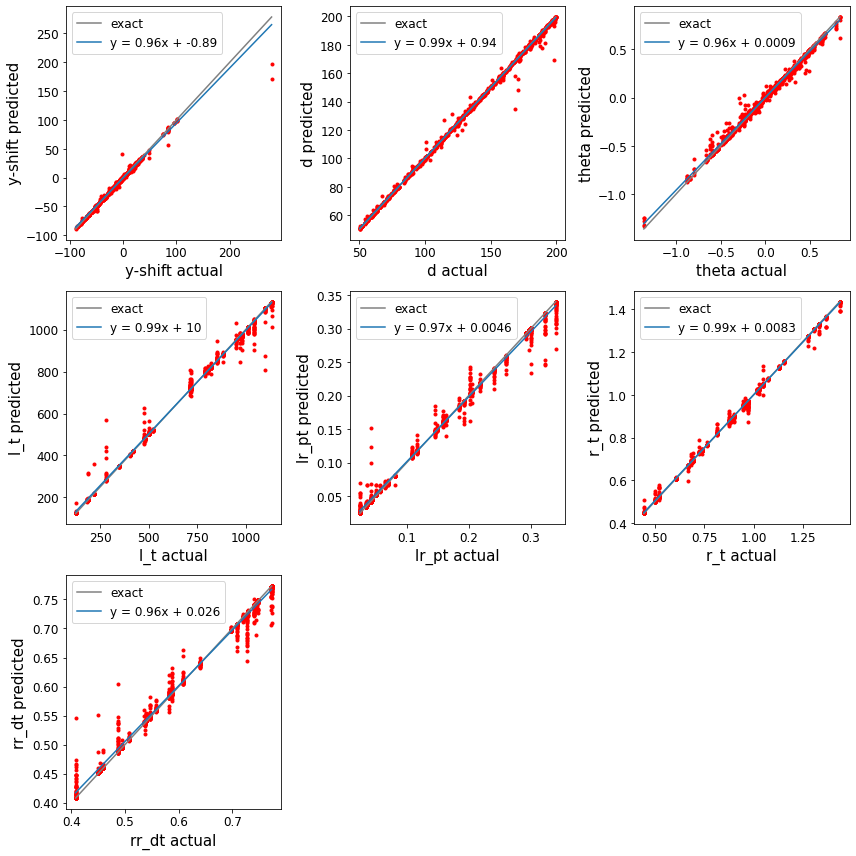

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

fig = plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

### Feature importance

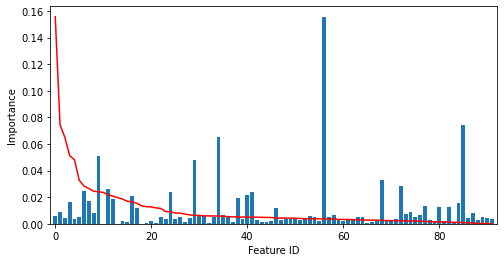

In [13]:
feat_df = pd.DataFrame({'id': range(model.n_features_in_), 'importance': model.feature_importances_,
                        'feature': summ_stats_names[:model.n_features_in_]})
feat_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

plt.figure(figsize=(8, 4))
plt.bar(feat_df['id'], feat_df['importance'])
plt.plot(feat_df['importance'].values, 'r')
plt.xlim(-1, len(feat_df))
plt.xlabel('Feature ID')
plt.ylabel('Importance')
plt.show()

In [14]:
cutoff_importance = 0.01
n_top = sum(feat_df['importance'] >= cutoff_importance)
top_feats = feat_df.iloc[:n_top]['id'].values

with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_df.iloc[:n_top])

,id,importance,feature
0,56,0.156,tr_l_w1
1,85,0.0744,log_avg_std
2,34,0.065,pk_mean
3,9,0.0513,t_tr_std
4,29,0.0481,tr_mean
5,68,0.0327,tr_l_avg_mag
6,72,0.0284,tr_l_t1
7,11,0.0265,t_tr_max_idx_y
8,6,0.0245,avg_min_idx_y
9,24,0.0241,stdev_mean


## Train on important features

In [15]:
model_red = RandomForestRegressor()
model_red.fit(summ_stats_train[:, top_feats], labels_train)

RandomForestRegressor()

### Evaluate model

In [16]:
y = labels_test.copy()
output = model_red.predict(summ_stats_test[:, top_feats])
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.04508
R2 Score:
y-shift,   0.987
d,         0.998
theta,     0.969
l_t,       0.995
lr_pt,     0.988
r_t,       0.998
rr_dt,     0.982


Stylized Cell Testing Data: Ground Truth VS Predicted


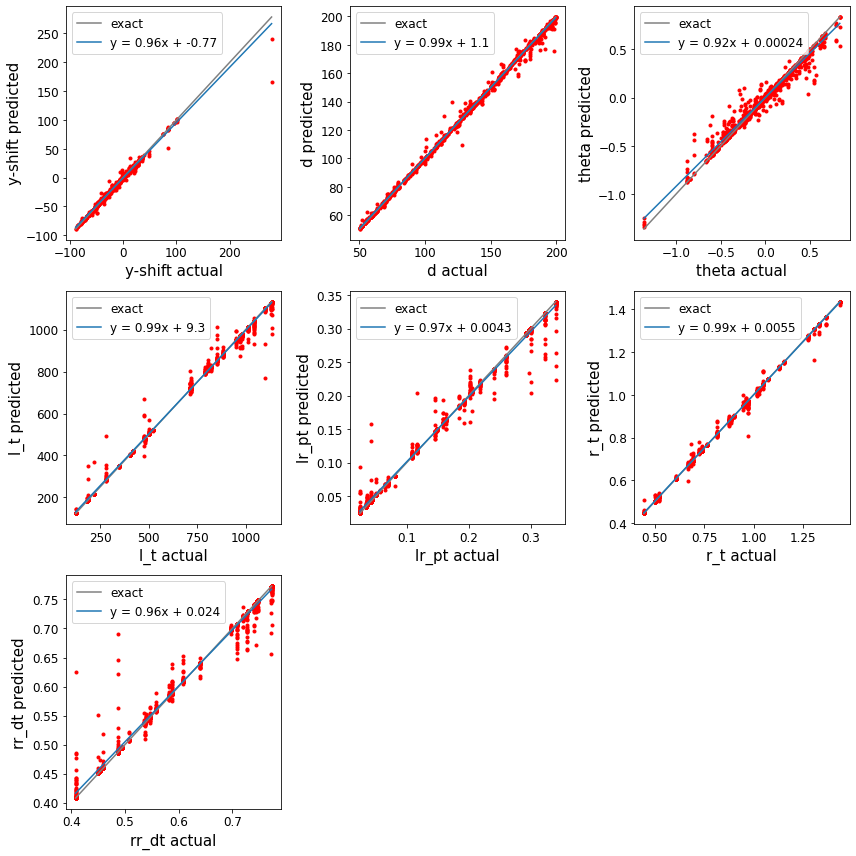

In [17]:
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

fig = plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

### Feature importance

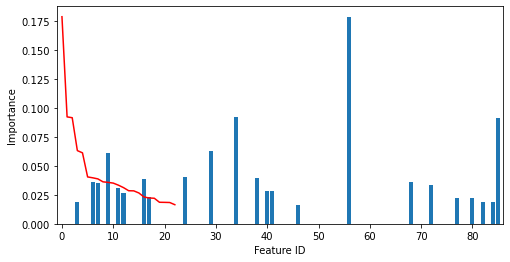

,id,importance,feature
0,56,0.179,tr_l_w1
1,34,0.0922,pk_mean
2,85,0.0915,log_avg_std
3,29,0.0631,tr_mean
4,9,0.0612,t_tr_std
5,24,0.0404,stdev_mean
6,38,0.0397,pk_max_val
7,16,0.0387,t_pk_mean
8,6,0.0362,avg_min_idx_y
9,68,0.0357,tr_l_avg_mag


In [18]:
feat_red_df = pd.DataFrame({'id': top_feats, 'importance': model_red.feature_importances_,
                            'feature': summ_stats_names[top_feats]})
feat_red_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

plt.figure(figsize=(8, 4))
plt.bar(feat_red_df['id'], feat_red_df['importance'])
plt.plot(feat_red_df['importance'].values, 'r')
plt.xlim(-1, feat_red_df['id'].max()+ 1)
plt.xlabel('Feature ID')
plt.ylabel('Importance')
plt.show()

with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_red_df)

## Train on selected outputs

In [19]:
select_label = ['l_t', 'lr_pt', 'r_t', 'rr_dt']
label_idx = [label_list.index(x) for x in select_label]

print(np.array(label_list)[label_idx])

['l_t' 'lr_pt' 'r_t' 'rr_dt']


In [20]:
model_sel = RandomForestRegressor()
model_sel.fit(summ_stats_train, labels_train[:, label_idx])

RandomForestRegressor()

### Evaluate model

In [21]:
y = labels_test.copy()[:, label_idx]
output = model_sel.predict(summ_stats_test)
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

print('R2 Score:')
for i, p in enumerate(label_idx):
    print('{:10} {:.3f}'.format(display_list[p]+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.05723
R2 Score:
l_t,       0.995
lr_pt,     0.984
r_t,       0.997
rr_dt,     0.976


### Feature importance

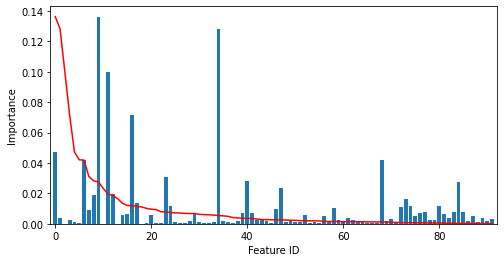

In [22]:
feat_labels_df = pd.DataFrame({'id': range(model_sel.n_features_in_), 'importance': model_sel.feature_importances_,
                        'feature': summ_stats_names[:model_sel.n_features_in_]})
feat_labels_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

plt.figure(figsize=(8, 4))
plt.bar(feat_labels_df['id'], feat_labels_df['importance'])
plt.plot(feat_labels_df['importance'].values, 'r')
plt.xlim(-1, len(feat_labels_df))
plt.xlabel('Feature ID')
plt.ylabel('Importance')
plt.show()

In [23]:
cutoff_importance = 0.01
n_top = sum(feat_labels_df['importance'] >= cutoff_importance)

with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_labels_df.iloc[:n_top])

,id,importance,feature
0,9,0.136,t_tr_std
1,34,0.128,pk_mean
2,11,0.0999,t_tr_max_idx_y
3,16,0.0714,t_pk_mean
4,0,0.0473,avg_mean
5,68,0.042,tr_l_avg_mag
6,6,0.0419,avg_min_idx_y
7,23,0.0311,t_pk_min_val
8,40,0.0283,t1
9,84,0.0275,log_avg_mean


## Train on individual output

In [24]:
model_label = []

for L_idx in label_idx:
    model_L = RandomForestRegressor()
    model_L.fit(summ_stats_train, labels_train[:, L_idx])
    model_label.append(model_L)

### Evaluate model

In [25]:
for model_L, L, L_idx in zip(model_label, select_label, label_idx):
    y = labels_test[:, L_idx]
    output = model_L.predict(summ_stats_test)
    rmse = mean_squared_error(y, output, squared=False)
    print(L)
    print(f'RMSE: {rmse: .4g}')
    print('R2 Score: {:.3f}'.format(r2_score(y, output)))

l_t
RMSE:  0.05601
R2 Score: 0.990
lr_pt
RMSE:  0.07005
R2 Score: 0.986
r_t
RMSE:  0.02524
R2 Score: 0.997
rr_dt
RMSE:  0.08763
R2 Score: 0.977


### Feature importance

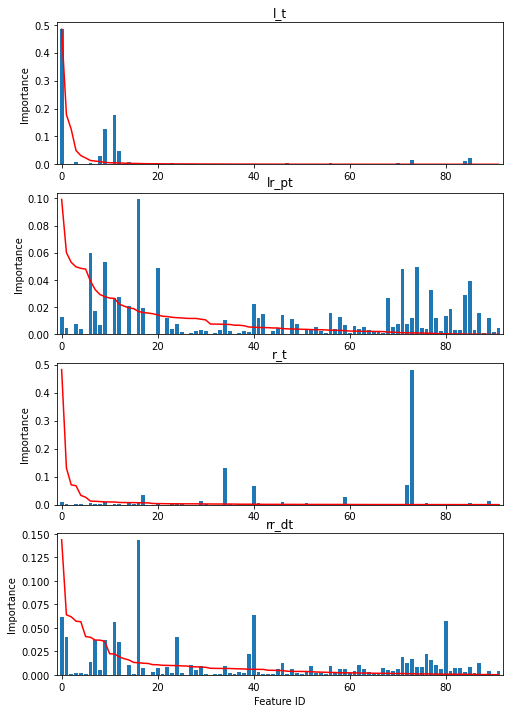

In [26]:
feat_label_df = {}
_, axs = plt.subplots(len(select_label), 1, figsize=(8, 3 * len(select_label)))

for model_L, L, ax in zip(model_label, select_label, axs):
    feat_L_df = pd.DataFrame({'id': range(model_L.n_features_in_), 'importance': model_L.feature_importances_,
                              'feature': summ_stats_names[:model_L.n_features_in_]})
    feat_L_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)
    feat_label_df[L] = feat_L_df

    ax.bar(feat_L_df['id'], feat_L_df['importance'])
    ax.plot(feat_L_df['importance'].values, 'r')
    ax.set_title(L)
    ax.set_xlim(-1, feat_L_df['id'].max()+ 1)
    ax.set_ylabel('Importance')
ax.set_xlabel('Feature ID')
plt.show()

In [27]:
feat_alllabel_df = pd.concat(feat_label_df, axis=1)
with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_alllabel_df)

l_t                             lr_pt                             r_t  \
    id importance          feature    id importance          feature  id   
0    0      0.484         avg_mean    16     0.0992        t_pk_mean  73   
1   11      0.178   t_tr_max_idx_y     6     0.0601    avg_min_idx_y  34   
2    9      0.125         t_tr_std     9     0.0529         t_tr_std  72   
3   12     0.0494     t_tr_max_val    74     0.0497          tr_r_t1  40   
4    8     0.0312        t_tr_mean    20     0.0486     t_pk_max_val  17   
5   85     0.0227      log_avg_std    71      0.048     pk_r_avg_mag  59   
6   73     0.0137          tr_l_t2    85     0.0393      log_avg_std  89   
7   84     0.0114     log_avg_mean    77     0.0329          pk_l_t2  29   
8   14    0.00966   t_tr_min_idx_y    84     0.0293     log_avg_mean  46   
9    3    0.00691    avg_max_idx_y    12     0.0278     t_tr_max_val  14   
10  56    0.00558          tr_l_w1    11     0.0267   t_tr_max_idx_y   9   
11  70    0.00507     pk_l_avg_mag    68     0.0265     tr_l_avg_mag   0   
12  16    0.00495        t_pk_mean    40     0.0223               t1  16   
13  23    0.00387     t_pk_min_val    14     0.0208   t_tr_min_idx_y  24   
14   6    0.00335    avg_min_idx_y    17     0.0196         t_pk_std  41   
15  47    0.00304     t1_min_idx_y    81      0.019       tr_r_tprop  85   
16  74    0.00282          tr_r_t1     7     0.0169      avg_min_val   6   
17  72    0.00221          tr_l_t1    87     0.0161    log_stdev_std  51   
18  68    0.00217     tr_l_avg_mag    56     0.0157          tr_l_w1  76   
19  40    0.00194               t1    42     0.0152  t0_half_l_idx_y  87   
20  87     0.0019    log_stdev_std    46     0.0144     t1_max_idx_y  84   
21   7    0.00163      avg_min_val    80     0.0134       tr_l_tprop  79   
22  58    0.00153          tr_l_y1    58     0.0131          tr_l_y1   3   
23  17    0.00137         t_pk_std     0     0.0126         avg_mean  81   
24  91    0.00128       log_pk_std    73     0.0123          tr_l_t2  11   
25  69    0.00126     tr_r_avg_mag    22     0.0121   t_pk_min_idx_y  12   
26  75    0.00124          tr_r_t2    41     0.0118               t2  61   
27  27    0.00122  stdev_max_idx_y    89     0.0118       log_tr_std  77   
28  77     0.0012          pk_l_t2    78     0.0118          pk_r_t1  74   
29  37   0.000988     pk_max_idx_y    48     0.0112      tr_lambda_l  58   
30  89   0.000988       log_tr_std    34     0.0107          pk_mean  71   
31  80   0.000967       tr_l_tprop    72    0.00766          tr_l_t1  47   
32   1   0.000961          avg_std    24    0.00762       stdev_mean  68   
33  76   0.000875          pk_l_t1    49    0.00756      tr_lambda_r  78   
34  39   0.000857               t0    70    0.00738     pk_l_avg_mag  39   
35  34   0.000764          pk_mean     3    0.00736    avg_max_idx_y  60   
36  83   0.000692       pk_r_tprop     8    0.00681        t_tr_mean  82   
37  81   0.000676       tr_r_tprop    59    0.00678          tr_r_w1   7   
38  29   0.000644          tr_mean    61    0.00641          tr_r_y1  91   
39  20   0.000629     t_pk_max_val    63    0.00548          pk_l_w2  37   
40  64     0.0006          pk_l_y1    53    0.00536      pk_lambda_r  25   
41  41   0.000543               t2    69    0.00517     tr_r_avg_mag  35   
42  61   0.000541          tr_r_y1    45    0.00501  t2_half_r_idx_y   8   
43  79   0.000534          pk_r_t2    75    0.00501          tr_r_t2  53   
44  24   0.000501       stdev_mean    91    0.00477       log_pk_std  80   
45  44   0.000433  t2_half_l_idx_y     1    0.00476          avg_std  75   
46  62   0.000422          pk_l_w1     4    0.00432      avg_max_val   1   
47  59    0.00036          tr_r_w1    76    0.00413          pk_l_t1  70   
48  15    0.00035     t_tr_min_val    51    0.00403       tr_slope_r  42   
49  63   0.000334          pk_l_w2    23    0.00394     t_pk_min_val  15   
50  82   0.000324       pk_l_tprop    57    0.00379